In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
engine = create_engine(
    'mssql+pyodbc://'
    'sa:123456@./DDS?' # username:pwd@server:port/database
    'driver=ODBC+Driver+17+for+SQL+Server'
    )

In [3]:
str =  'SELECT \
	ROW_NUMBER() OVER (ORDER BY F.PHUID, F.DateID, F.GenderID) AS ID \
	, DP.PHUName \
	, DP.CityName \
	, DP.GroupName \
	, DD.Date \
	, CONCAT (''{}'', CAST(DD.Quarter AS varchar),''{}'', CAST(DD.Year AS varchar)) AS TimePeriod \
	, DG.Gender \
	, DE.ExposureName \
	, DA.Age \
	, DO.Outcome \
	, DS.Severity \
FROM FactCaseDetail F \
	JOIN DimPHU DP ON DP.PHUID_SK = F.PHUID \
	JOIN DimDate DD ON DD.DateID = F.DateID \
	JOIN DimGender DG ON DG.GenderID = F.GenderID \
	JOIN DimExposure DE ON DE.ExposureID = F.ExposureID \
	JOIN DimAge DA ON DA.AgeID = F.AgeID \
	JOIN DimOutcome DO ON DO.OutcomeID = F.OutcomeID \
	JOIN DimSeverity DS ON DS.SeverityID = F.SeverityID'.format('Q', '-')
str

'SELECT \tROW_NUMBER() OVER (ORDER BY F.PHUID, F.DateID, F.GenderID) AS ID \t, DP.PHUName \t, DP.CityName \t, DP.GroupName \t, DD.Date \t, CONCAT (Q, CAST(DD.Quarter AS varchar),-, CAST(DD.Year AS varchar)) AS TimePeriod \t, DG.Gender \t, DE.ExposureName \t, DA.Age \t, DO.Outcome \t, DS.Severity FROM FactCaseDetail F \tJOIN DimPHU DP ON DP.PHUID_SK = F.PHUID \tJOIN DimDate DD ON DD.DateID = F.DateID \tJOIN DimGender DG ON DG.GenderID = F.GenderID \tJOIN DimExposure DE ON DE.ExposureID = F.ExposureID \tJOIN DimAge DA ON DA.AgeID = F.AgeID \tJOIN DimOutcome DO ON DO.OutcomeID = F.OutcomeID \tJOIN DimSeverity DS ON DS.SeverityID = F.SeverityID'

In [4]:
df = pd.read_sql(
      'SELECT *\
		 FROM miningCaseDetail',
  engine,
  index_col='ID')
df

,PHUName,CityName,GroupName,Date,TimePeriod,Year,GenderID,Gender,ExposureID,ExposureName,AgeID,Age,OutcomeID,Outcome,SeverityID,Severity,Label1,Label2,Label3
ID,,,,,,,,,,,,,,,,,,,
58875,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,3,male,1,CC,5,20-29,3,Recovered,1,Low,Cluster 4,Cluster1,None
58876,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,3,male,1,CC,6,30-39,3,Recovered,1,Low,Cluster 9,Cluster1,None
58877,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,3,male,1,CC,7,40-49,3,Recovered,1,Low,Cluster 9,Cluster1,None
58878,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,3,male,1,CC,8,50-59,3,Recovered,2,Moderate,Cluster 5,Cluster1,None
58879,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,3,male,1,CC,9,60-69,3,Recovered,2,Moderate,Cluster 5,Cluster1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58870,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,1,female,3,NOT REPORTED,9,60-69,3,Recovered,2,Moderate,Cluster 6,Cluster4,None
58871,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,1,female,4,OB,7,40-49,3,Recovered,1,Low,Cluster 1,Cluster8,None
58872,Niagara Region Public Health Department,Thorold,Hamilton Niagara Haldimand Brant,2021-04-22,Q2/2021,2021,1,female,4,OB,9,60-69,2,Deceased,4,Critical,Cluster 8,Cluster4,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174596 entries, 58875 to 58874
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   PHUName       174596 non-null  object
 1   CityName      174596 non-null  object
 2   GroupName     174596 non-null  object
 3   Date          174596 non-null  object
 4   TimePeriod    174596 non-null  object
 5   Year          174596 non-null  int64 
 6   GenderID      174596 non-null  int64 
 7   Gender        174596 non-null  object
 8   ExposureID    174596 non-null  int64 
 9   ExposureName  174596 non-null  object
 10  AgeID         174596 non-null  int64 
 11  Age           174596 non-null  object
 12  OutcomeID     174596 non-null  int64 
 13  Outcome       174596 non-null  object
 14  SeverityID    174596 non-null  int64 
 15  Severity      174596 non-null  object
 16  Label1        174596 non-null  object
 17  Label2        174596 non-null  object
 18  Label3        0 non-n

In [6]:
df.columns

Index(['PHUName', 'CityName', 'GroupName', 'Date', 'TimePeriod', 'Year',
       'GenderID', 'Gender', 'ExposureID', 'ExposureName', 'AgeID', 'Age',
       'OutcomeID', 'Outcome', 'SeverityID', 'Severity', 'Label1', 'Label2',
       'Label3'],
      dtype='object')

#### Declare feature vector and target variable

In [21]:
X= df[['TimePeriod','AgeID','OutcomeID', 'GroupName']]
X.columns

Index(['TimePeriod', 'AgeID', 'OutcomeID', 'GroupName'], dtype='object')

#### Convert categorical variable into integers

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174596 entries, 58875 to 58874
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   TimePeriod  174596 non-null  object
 1   AgeID       174596 non-null  int64 
 2   OutcomeID   174596 non-null  int64 
 3   GroupName   174596 non-null  object
dtypes: int64(2), object(2)
memory usage: 6.7+ MB


In [23]:
label_encoder = preprocessing.LabelEncoder()

X.GroupName= label_encoder.fit_transform(X.GroupName)
X.TimePeriod= label_encoder.fit_transform(X.TimePeriod)
X

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10448\686363112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.GroupName= label_encoder.fit_transform(X.GroupName)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10448\686363112.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.TimePeriod= label_encoder.fit_transform(X.TimePeriod)


,TimePeriod,AgeID,OutcomeID,GroupName
ID,,,,
58875,3,5,3,5
58876,3,6,3,5
58877,3,7,3,5
58878,3,8,3,5
58879,3,9,3,5
...,...,...,...,...
58870,3,9,3,5
58871,3,7,3,5
58872,3,9,2,5


#### Feature Scaling 

In [24]:
ms = preprocessing.MinMaxScaler()
X = ms.fit_transform(X)

#### Use elbow method to find optimal number of clusters 

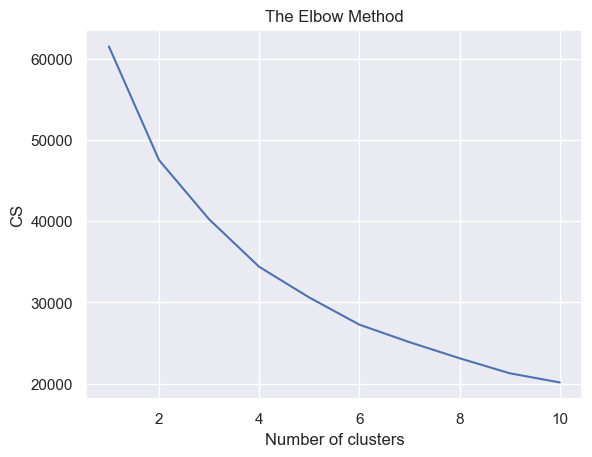

In [11]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 600, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

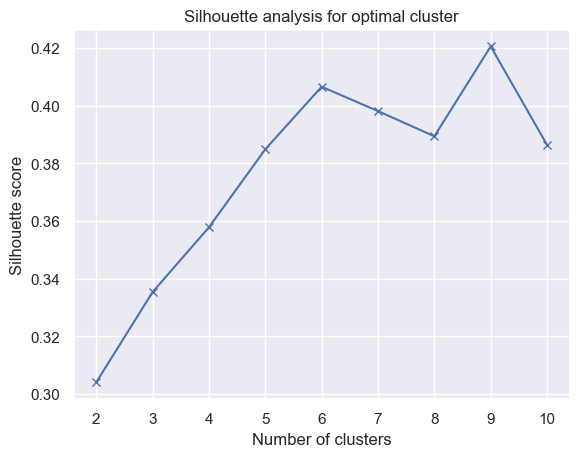

In [8]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(X, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis for optimal cluster')
plt.show()

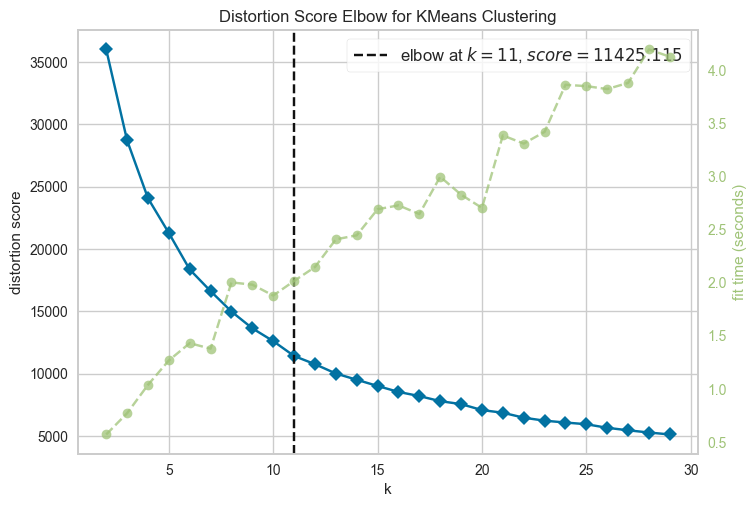

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(X)        # Fit data to visualizer
visualizer.show()     

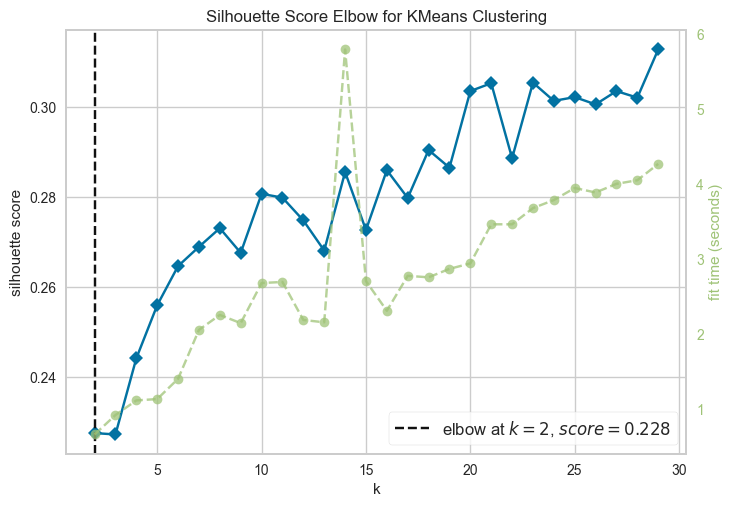

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### K-Means model

In [26]:
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=600, init = 'k-means++', n_init = 10, algorithm = 'auto')
kmeans.fit(X)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='auto', max_iter=600, n_clusters=5, random_state=0)

In [27]:
df['Label']=kmeans.labels_
labels = kmeans.labels_

In [28]:
df.to_sql('temp_table', engine, if_exists='replace')

sql = """
    UPDATE m
    SET Label = 'Cluster ' + cast(t.Label as varchar)
    FROM miningCaseDetail AS m join temp_table AS t ON m.id = t.id
"""

with engine.begin() as conn:     # TRANSACTION
    conn.execute(sql)